In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
import trend_seasonality
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [86]:
df_asl = pd.read_csv('s3://phmsbi-cpd-analytics-dev/jan_rathfelder/ita/xrlt/impact_attribution.predictive_modeling/model_input_asl_new.csv') 
df_asl['yyyymm'] = pd.to_datetime(df_asl.yyyymm)

df_asl = df_asl[(df_asl.asl!='FABRIANO')
               ].copy()
df_asl['month'] = df_asl['yyyymm'].dt.month
df_asl['week'] = df_asl['yyyymm'].dt.week

a = pd.get_dummies(df_asl.month, prefix='month')
a.drop([a.columns[-1]],axis =1, inplace=True)

b = pd.get_dummies(df_asl.week, prefix='week')
b.drop([b.columns[-1]],axis =1, inplace=True)

c = pd.get_dummies(df_asl.asl, prefix='dummy')
c.drop([c.columns[25]],axis =1, inplace=True)

d = pd.get_dummies(df_asl.region, prefix='dummy')
d.drop([d.columns[5]],axis =1, inplace=True)

e = pd.get_dummies(df_asl.macro, prefix='dummy', drop_first=True)

df_asl = pd.merge(df_asl, a, left_index=True, right_index=True)
df_asl = pd.merge(df_asl, b, left_index=True, right_index=True)
df_asl = pd.merge(df_asl, c, left_index=True, right_index=True)
df_asl = pd.merge(df_asl, d, left_index=True, right_index=True)
df_asl = pd.merge(df_asl, e, left_index=True, right_index=True)

In [87]:
# initialize module:
stl = trend_seasonality.stl_decomposition('asl','yyyymm')

# apply trend and seasonality cleaning / extraction:
df_asl = stl.decomposition(df_asl, 'sales_per_hcp','multiplicative')
df_asl = stl.decomposition(df_asl, 'num_cph_visit','multiplicative')
df_asl = stl.decomposition(df_asl, 'num_AE_cph','multiplicative')
df_asl = stl.decomposition(df_asl, 'num_NL_cph','multiplicative')
df_asl = stl.decomposition(df_asl, 'num_nocph_visit','multiplicative')
df_asl = stl.decomposition(df_asl, 'no_cph_all','multiplicative')
df_asl = stl.decomposition(df_asl, 'cph_all','multiplicative')

In [88]:
features = [
    'num_cph_visit_1_to_4m_mean',
    'num_nocph_visit_1_to_4m_mean',
           ]

time_features = ['sales_per_hcp_detrended_shift1',
 'sales_per_hcp_detrended_shift2',
 'sales_per_hcp_detrended_shift3',
 'sales_per_hcp_detrended_shift4',
 'sales_per_hcp_detrended_shift5',
 'sales_per_hcp_detrended_shift6',
 'sales_per_hcp_detrended_shift7',
 'sales_per_hcp_detrended_shift8',
 'sales_per_hcp_detrended_shift9',
 'sales_per_hcp_detrended_shift10',
                ]
target = 'sales_per_hcp_detrended'

In [6]:
features = [
    'num_cph_visit_1_to_4m_mean',
    'num_nocph_visit_1_to_4m_mean',
           ]

time_features = ['sales_per_hcp_detrended_deseasonalized_shift1',
 'sales_per_hcp_detrended_deseasonalized_shift2',
 'sales_per_hcp_detrended_deseasonalized_shift3',
 'sales_per_hcp_detrended_deseasonalized_shift4',
 'sales_per_hcp_detrended_deseasonalized_shift5',
 'sales_per_hcp_detrended_deseasonalized_shift6',
 'sales_per_hcp_detrended_deseasonalized_shift7',
 'sales_per_hcp_detrended_deseasonalized_shift8',
 #'sales_per_hcp_detrended_deseasonalized_shift9',
 #'sales_per_hcp_detrended_deseasonalized_shift10',
                ]
target = 'sales_per_hcp_detrended_deseasonalized'

In [1]:
scaler = MinMaxScaler()

normalize = 1
normalize_asl = 0
differencing = 0
outlier_cleaning = 0
eliptic = 0
ols = 1

grouping='asl'

features_to_be_used = [features
                       #+diff_features
                       +time_features
                       +['const']
                       #+['month']
                       #+meta_features
                       #+d.columns.values.tolist() # region
                       +a.columns.values.tolist() # month
                       +c.columns.values.tolist() # asl
                       #+e.columns.values.tolist() # macro
                       ]

df_asl2 = df_asl.copy()
df_asl2['const']=1

if differencing == 1:
    df_asl2[features] = df_asl2.groupby(grouping)[features].diff()

df_asl2 = df_asl2[[target]+features_to_be_used[0]+['asl','yyyymm',
                  'sales_per_hcp_shift1',
                  'sales_per_hcp',
                  'sales_per_hcp_trend',
                  'region',
                  #'num_hcp_asl_mccp',
                   #'num_touchpoints_cph',
                   #'reached_cph',
                   'coverage_12m_cph',
                    'consistency_12m_cph',
                    'coverage_4m_cph',
                    'consistency_4m_cph',
                  'macro',
                                                    'num_channel_cph',
 'num_touchpoints_cph',
 'coverage_cph',
 'num_channel_nocph',
 'num_touchpoints_nocph',
                  #'macro_dummy'
                  #'cph_all',
                  #'no_cph_all'
                 ]].dropna().copy()


# outlier cleaning:
if outlier_cleaning==1:

    dfx = df_asl2.copy()
    
    if eliptic == 1:
        cov = EllipticEnvelope(random_state=0).fit(dfx[features])
        # predict returns 1 for an inlier and -1 for an outlier
        a = cov.predict(dfx[features])
        df_asl2['outlier'] = a
    ###############
    else:
        clf = IsolationForest(random_state=0).fit(dfx[features])
        b = clf.predict(dfx[features])
        df_asl2['outlier'] = b
       
    print(df_asl2[df_asl2.outlier==1].shape[0] / df_asl2.shape[0])
    df_asl2 = df_asl2[df_asl2.outlier==1].copy()
    df_asl2.reset_index(drop=True,inplace=True)
    
if normalize == 1:
    df_asl2[features_to_be_used[0]] = df_asl2[features_to_be_used[0]].dropna()
    
    if normalize_asl == 1:
        print('normalize asl lvl')
        for feat in features:
            temp1 = df_asl2.groupby('asl').apply(lambda x: np.concatenate(scaler.fit_transform(
            x[feat].values.reshape(-1, 1))))     
            norm_stacked = np.hstack(temp1)
            df_asl2[feat] = norm_stacked  
    else:
        print('normalize')
        for feat in features:
            df_asl2[feat] = scaler.fit_transform(df_asl2[feat].values.reshape(-1, 1))
           
   # for feat in features:
    if feat.find('consistency') != -1:
        df_asl2[feat] = scaler.fit_transform(df_asl2[feat].values.reshape(-1, 1))
    elif feat.find('coverage') != -1:
        df_asl2[feat] = scaler.fit_transform(df_asl2[feat].values.reshape(-1, 1))
               
if ols==1:   
    #mod = sm.MixedLM(df_asl2[target], 
    #           df_asl2[features_to_be_used[0]], 
    #           groups=df_asl2["asl"], 
    #          exog_re=df_asl2[features[0]]
    #         )
    #res = mod.fit(reml=False)

    mod = sm.OLS(df_asl2[target], df_asl2[
             features_to_be_used[0]])  
    res = mod.fit(cov_type='HAC',cov_kwds={'maxlags':3})
    dfx = pd.DataFrame(res.params)
    cols_used = dfx.index
    print(res.summary())
else:
    res = XGBRegressor(n_estimators=500,
                   max_depth=5,
                   learning_rate=.01)
    res.fit(df_asl2[
             features_to_be_used[0]], 
              df_asl2[target])
    
    # Initialize the KFold parameters
    kfold = KFold(n_splits=5, random_state=7)
    # Perform K-Fold Cross Validation
    results = cross_val_score(res, df_asl2[
                             features_to_be_used[0]], 
                             df_asl2[target], cv=kfold)
    # Print the average results
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

NameError: name 'MinMaxScaler' is not defined

Text(0.5, 1.0, 'True vs Predictions')

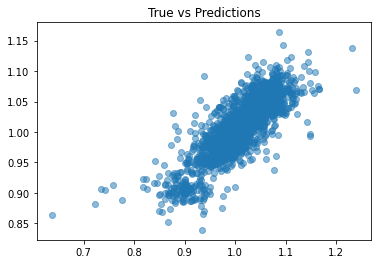

In [90]:
# plot true vs prediction on training data:

plt.scatter(df_asl2[target], 
            #res.resid, 
            res.predict(df_asl2[features_to_be_used[0]]),
            alpha = 0.5)
plt.title('True vs Predictions')

In [91]:
zero_feature = features[0]

preds =  res.predict(df_asl2[cols_used])
df_asl2[zero_feature] = df_asl2[zero_feature].apply(lambda x: x*0)
preds_zero = res.predict(df_asl2[cols_used])

df_asl2['preds_original'] = preds
df_asl2['preds_zero'] = preds_zero
df_asl2['impact'] = df_asl2.preds_original - df_asl2.preds_zero

/home/jan_rathfelder/Development/scale-up-codebase/env_1/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


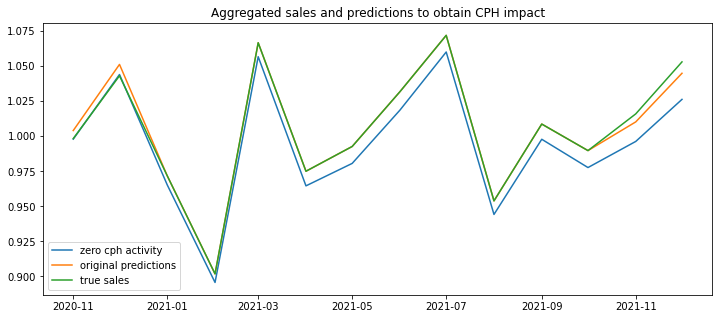

In [92]:
gr = df_asl2.groupby('yyyymm')['preds_original', 
                               'preds_zero',
                               'impact',
                               target,
                               'sales_per_hcp_trend'
                              ].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(gr.yyyymm,
         gr.preds_zero, label='zero cph activity')
plt.plot(gr.yyyymm,
         gr.preds_original, label='original predictions')
plt.plot(gr.yyyymm,
         gr[target], label='true sales')
plt.legend()
plt.title('Aggregated sales and predictions to obtain CPH impact')
plt.show()

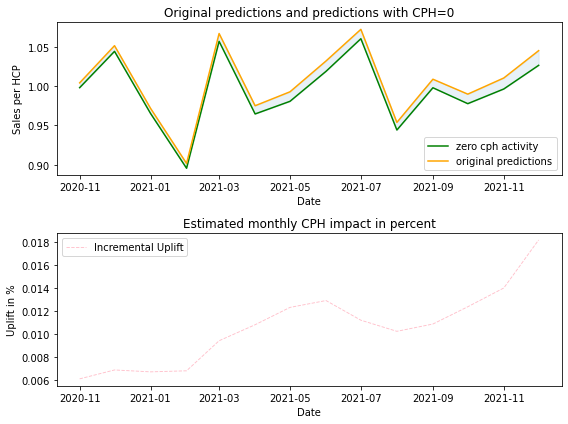

In [93]:
gr['uplift'] = gr.preds_original / gr.preds_zero - 1

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
axes[0].plot(gr.yyyymm,
             gr.preds_zero, color='green', label='zero cph activity')
axes[0].plot(gr.yyyymm,
         gr.preds_original, color='orange', label='original predictions')
axes[0].fill_between(gr.yyyymm, gr.preds_zero, gr.preds_original, color='C0', alpha=0.1)
axes[0].set_title('Original predictions and predictions with CPH=0')
axes[0].set_ylabel('Sales per HCP')
axes[0].set_xlabel('Date')
axes[0].legend()
axes[1].plot(gr.yyyymm,gr.uplift, label='Incremental Uplift', color='pink', ls='--', lw=.9)
axes[1].set_title('Estimated monthly CPH impact in percent')
axes[1].set_ylabel('Uplift in %')
axes[1].set_xlabel('Date')
axes[1].legend()
fig.tight_layout()

In [94]:
np.sum(gr[gr.yyyymm>='2021-01-01'].preds_original)/np.sum(gr[gr.yyyymm>='2021-01-01'].preds_zero)-1

0.01138933775363804

### Consistency Analysis

In [95]:
gr = df_asl2[df_asl2.yyyymm>='2021-01-01'].groupby(['asl','region'])[['preds_original',
                                                                'preds_zero',
                                      
                              'coverage_12m_cph',
                              'consistency_12m_cph',
                                'coverage_4m_cph',
                              'consistency_4m_cph',
                                         'num_channel_cph',
 'num_touchpoints_cph',
 'coverage_cph',
 'num_channel_nocph',
 'num_touchpoints_nocph',
                              'impact']
                                     +features+
                            [target]].mean().reset_index()

In [96]:
# mean centering to avoid multi-collinearity issues

cov_mean = gr['coverage_12m_cph'].mean()
const_mean = gr['consistency_12m_cph'].mean()

gr['center_coverage_12m_cph'] = gr['coverage_12m_cph'].subtract(
    gr['coverage_12m_cph'].mean())

gr['center_consistency_12m_cph'] = gr['consistency_12m_cph'].subtract(
    gr['consistency_12m_cph'].mean())

gr['center_num_touchpoints_cph'] = gr['num_touchpoints_cph'].subtract(
    gr['num_touchpoints_cph'].mean())

gr['center_int_cov_const_12m'] = gr.center_coverage_12m_cph * gr.center_consistency_12m_cph
gr['center_int_touch_const_12m'] = gr.center_num_touchpoints_cph * gr.center_consistency_12m_cph
gr['center_int_touch_cov_12m'] = gr.center_num_touchpoints_cph * gr.center_coverage_12m_cph

for feat in ['center_coverage_12m_cph',
             'center_consistency_12m_cph',
             'center_num_touchpoints_cph',
             'center_int_cov_const_12m',
             'center_int_touch_const_12m',
             'center_int_touch_cov_12m']:
    gr['scaled_'+feat] = scaler.fit_transform(gr[feat].values.reshape(-1, 1))

In [97]:
cols_for_impact= [ 'constant',
                   'scaled_center_coverage_12m_cph', 
                   'scaled_center_consistency_12m_cph',
                  'scaled_center_int_cov_const_12m',
                ]

In [98]:
gr = gr.dropna()

gr['constant']=1
log_model=0

if log_model == 1:
    mod = sm.OLS(gr.log_impact, 
                 gr[cols_for_impact_log
    ],missing='drop')
    res = mod.fit()
    print(res.summary())
else:
    mod = sm.OLS(gr.impact, 
                 gr[cols_for_impact
    ],missing='drop')
    res = mod.fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 impact   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     115.1
Date:                Fri, 16 Sep 2022   Prob (F-statistic):           1.24e-34
Time:                        10:06:45   Log-Likelihood:                 487.24
No. Observations:                 120   AIC:                            -966.5
Df Residuals:                     116   BIC:                            -955.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
consta

In [99]:
rate = .01
touchp = 0

if log_model==0:
    if touchp==1:
        preds_impact = res.predict(gr[cols_for_impact])
        gr2 = gr.copy()
        gr2[cols_for_impact[1]] = gr2[cols_for_impact[1]].apply(lambda x: x*(1+rate))
        #gr2[cols_for_impact[4]] = gr2[cols_for_impact[1]]**2
        gr2[cols_for_impact[-1]] = gr2[cols_for_impact[-1]].apply(lambda x: x*(1+rate))
        preds_coverage_impact = res.predict(gr2[cols_for_impact])

        gr3 = gr.copy()
        gr3[cols_for_impact[2]] = gr3[cols_for_impact[2]].apply(lambda x: x*(1+rate))
        #gr3[cols_for_impact[4]] = gr3[cols_for_impact[2]]**2
        gr3[cols_for_impact[-1]] = gr3[cols_for_impact[-1]].apply(lambda x: x*(1+rate))
        preds_consistency_impact = res.predict(gr3[cols_for_impact])

        gr4 = gr.copy()
        gr4[cols_for_impact[3]] = gr4[cols_for_impact[3]].apply(lambda x: x*(1+rate))
        #gr3[cols_for_impact[4]] = gr3[cols_for_impact[2]]**2
        #gr3[cols_for_impact[-1]] = gr3[cols_for_impact[-1]].apply(lambda x: x*(1+rate))
        preds_touchpoints_impact = res.predict(gr4[cols_for_impact])
        
        gr['preds_impact'] = preds_impact
        gr['preds_coverage_uplift'] = preds_coverage_impact
        gr['preds_consistency_uplift'] = preds_consistency_impact
        gr['preds_touchpoints_uplift'] = preds_touchpoints_impact
        
        gr['delta_coverage'] = gr.preds_coverage_uplift/gr.preds_impact-1
        gr['delta_consistency'] = gr.preds_consistency_uplift/gr.preds_impact-1
        gr['delta_touchpoints'] = gr.preds_touchpoints_uplift/gr.preds_impact-1

        gr['max_value']=gr[['delta_consistency',
           'delta_coverage',
            'delta_touchpoints']].apply(lambda x: np.max([x[0],x[1],x[2]]), axis=1)
        gr['recommendation'] = np.where(gr.max_value==gr.delta_consistency,1,
                                np.where(gr.max_value==gr.delta_coverage,2,3))
    else:
        preds_impact = res.predict(gr[cols_for_impact])
        gr2 = gr.copy()
        gr2[cols_for_impact[1]] = gr2[cols_for_impact[1]].apply(lambda x: x*(1+rate))
        #gr2[cols_for_impact[4]] = gr2[cols_for_impact[1]]**2
        gr2[cols_for_impact[-1]] = gr2[cols_for_impact[-1]].apply(lambda x: x*(1+rate))
        preds_coverage_impact = res.predict(gr2[cols_for_impact])

        gr3 = gr.copy()
        gr3[cols_for_impact[2]] = gr3[cols_for_impact[2]].apply(lambda x: x*(1+rate))
        #gr3[cols_for_impact[4]] = gr3[cols_for_impact[2]]**2
        gr3[cols_for_impact[-1]] = gr3[cols_for_impact[-1]].apply(lambda x: x*(1+rate))
        preds_consistency_impact = res.predict(gr3[cols_for_impact])

        gr4 = gr.copy()
        gr4[cols_for_impact[3]] = gr4[cols_for_impact[3]].apply(lambda x: x*(1+rate))
        #gr3[cols_for_impact[4]] = gr3[cols_for_impact[2]]**2
        #gr3[cols_for_impact[-1]] = gr3[cols_for_impact[-1]].apply(lambda x: x*(1+rate))
        preds_touchpoints_impact = res.predict(gr4[cols_for_impact])
        
        gr['preds_impact'] = preds_impact
        gr['preds_coverage_uplift'] = preds_coverage_impact
        gr['preds_consistency_uplift'] = preds_consistency_impact

        gr['delta_coverage'] = gr.preds_coverage_uplift/gr.preds_impact-1
        gr['delta_consistency'] = gr.preds_consistency_uplift/gr.preds_impact-1
        gr['recommendation'] = np.where(gr.delta_consistency > gr.delta_coverage,
                               1,2)

else:
    preds_impact = res.predict(gr[cols_for_impact_log])
    gr2 = gr.copy()
    gr2[cols_for_impact_log[1]] = gr2[cols_for_impact_log[1]].apply(lambda x: x*(1+rate))
    gr2[cols_for_impact_log[-1]] = gr2[cols_for_impact_log[-1]].apply(lambda x: x*(1+rate))
    preds_coverage_impact = res.predict(gr2[cols_for_impact_log])

    gr3 = gr.copy()
    gr3[cols_for_impact_log[2]] = gr3[cols_for_impact_log[2]].apply(lambda x: x*(1+rate))
    gr3[cols_for_impact_log[-1]] = gr3[cols_for_impact_log[-1]].apply(lambda x: x*(1+rate))
    preds_consistency_impact = res.predict(gr3[cols_for_impact_log])

In [100]:
gr.recommendation.value_counts(True)

1    0.983333
2    0.016667
Name: recommendation, dtype: float64

In [101]:
print(gr.recommendation.value_counts(True))
gr.groupby('recommendation')[[
     'consistency_12m_cph',
    'coverage_12m_cph',
                         'impact']].mean()

1    0.983333
2    0.016667
Name: recommendation, dtype: float64


,consistency_12m_cph,coverage_12m_cph,impact
recommendation,,,
1,3.249905,0.720001,0.011470
2,0.946759,0.370536,0.000051


In [102]:
gr[['asl', 'consistency_12m_cph', 'coverage_12m_cph', 'impact', 'recommendation']].sample(10)

,asl,consistency_12m_cph,coverage_12m_cph,impact,recommendation
97,ATS DI PAVIA,3.503701,0.832512,0.009033,1
31,ASL DELLA ROMAGNA,3.428383,0.763333,0.008257,1
72,ASL VITERBO,2.593900,0.755435,0.012483,1
80,ASP ENNA,2.912628,0.625000,0.010187,1
70,ASL VC,2.350216,0.726389,0.009025,1
111,ULSS 2 MARCA TREVIGIANA,1.749010,0.558060,0.003471,1
108,S. BENEDETTO DEL TRONTO,1.981733,0.535714,0.004760,1
24,ASL BR/1,3.385713,0.860806,0.010246,1
38,ASL LANCIANO - VASTO - CHIETI,3.788713,0.847005,0.013550,1
102,CAMERINO,2.500000,0.423077,0.003040,1


##### Clustering based on coverage and consistency

In [103]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42).fit(gr[['coverage_12m_cph', 'consistency_12m_cph']])
clust = kmeans.predict(gr[['coverage_12m_cph', 'consistency_12m_cph']])

gr['clusters'] = clust

In [104]:
gr.groupby('clusters')['impact',
                      'coverage_12m_cph',
                      'consistency_12m_cph',
                       'num_touchpoints_cph',
                      'recommendation'].mean()

/home/jan_rathfelder/Development/scale-up-codebase/env_1/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,impact,coverage_12m_cph,consistency_12m_cph,num_touchpoints_cph,recommendation
clusters,,,,,
0,0.005960,0.628953,2.162147,1.913596,1.046512
1,0.022697,0.817381,5.002849,2.712040,1.000000
2,0.011082,0.740915,3.345538,2.328891,1.000000


Text(0.5, 1.0, 'Estimated impact vs touchpoints')

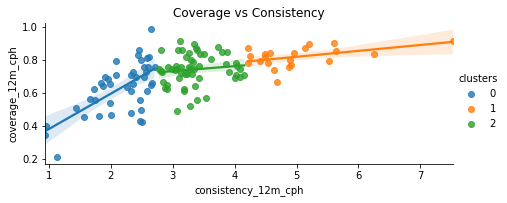

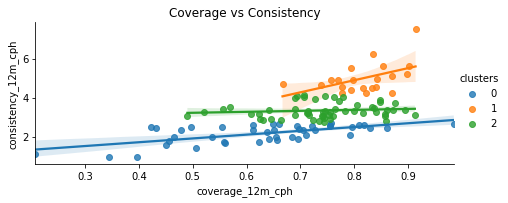

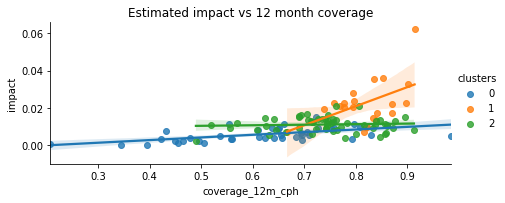

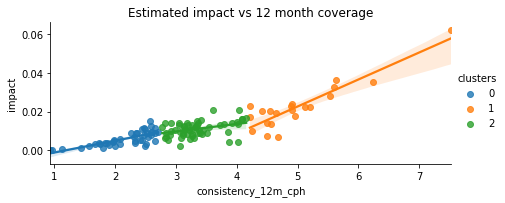

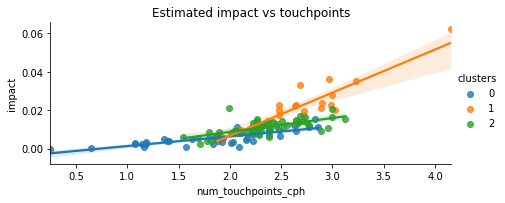

In [105]:
sns.lmplot(x='consistency_12m_cph',
           y='coverage_12m_cph',
           hue='clusters',
           data=gr,
           height=2.5, 
           aspect=10/4
               )
plt.title('Coverage vs Consistency')

sns.lmplot(x='coverage_12m_cph',
           y='consistency_12m_cph',
           hue='clusters',
           data=gr,
           height=2.5, 
           aspect=10/4
               )
plt.title('Coverage vs Consistency')


sns.lmplot(x='coverage_12m_cph',
           y='impact',
           hue='clusters',
           data=gr,
           height=2.5, 
           aspect=10/4
               )
plt.title('Estimated impact vs 12 month coverage')


sns.lmplot(x='consistency_12m_cph',
           y='impact',
           hue='clusters',
           data=gr,
           height=2.5, 
           aspect=10/4
               )
plt.title('Estimated impact vs 12 month coverage')

sns.lmplot(x='num_touchpoints_cph',
           y='impact',
           hue='clusters',
           data=gr,
           height=2.5, 
           aspect=10/4
               )
plt.title('Estimated impact vs touchpoints')

In [106]:
# find closest neighbour for coverage:

closest_neighbour = []

for i in gr[gr.clusters==1][['coverage_12m_cph']].values:
    results_temp = i - gr[gr.clusters!=1][['coverage_12m_cph']].values
    closest_neighbour.append(np.argmin(abs(results_temp)))

control_asls = gr[gr.clusters!=1].asl.unique()
c_group = control_asls[closest_neighbour]

t_group = gr[gr.clusters==1].asl.unique()

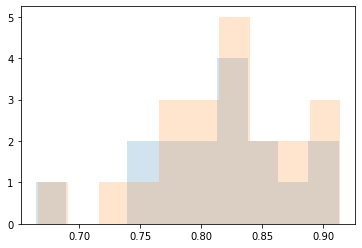

In [107]:
plt.hist(gr[gr.asl.isin(c_group)].coverage_12m_cph,
        alpha=.2)
plt.hist(gr[gr.clusters==1].coverage_12m_cph,
        alpha=.2)
plt.show()

In [108]:
df_asl = df_asl.merge(df_asl2[['asl','yyyymm','impact']],
                     on=['asl','yyyymm'],
                     how='left')

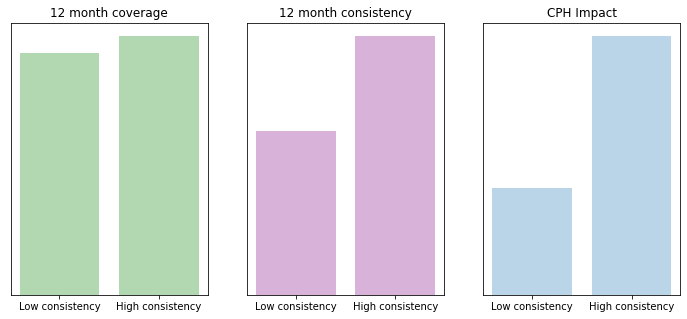

In [109]:
# find values and plot:

var_list_sales = ['coverage_12m_cph','consistency_12m_cph',
                 #'num_cph_visit_1_to_4m_mean',
                  #'xrlt_ms',
                  'impact'
                 ]

values = []
for n,feat in enumerate(var_list_sales):
    values.append([df_asl[df_asl.asl.isin(c_group)][feat].mean(),
            df_asl[df_asl.asl.isin(t_group)][feat].mean()])

# plot: 
f, (ax1, ax2, 
    ax3, 
    #ax4
   ) = plt.subplots(1, 3, 
                             #sharey=True,
                            figsize=(12,5))

ax1.bar(['Low consistency','High consistency'], values[0],
       color='green',
       alpha=.3)
ax1.set_title('12 month coverage')
ax1.set_yticks([])

ax2.bar(['Low consistency','High consistency'], values[1],
        color='purple',
        alpha=.3)
ax2.set_title('12 month consistency')
ax2.set_yticks([])

#ax3.bar(['Low consistency','High consistency'], values[2],
 #      alpha=.3)
#ax3.set_title('CPH Visits')

ax3.bar(['Low consistency','High consistency'], values[2],
       alpha=.3)
ax3.set_title('CPH Impact')
ax3.set_yticks([])

plt.show()

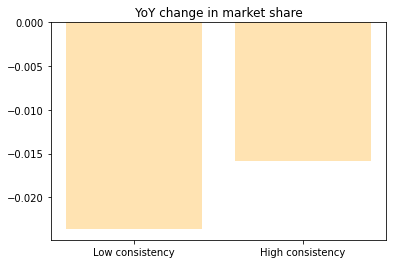

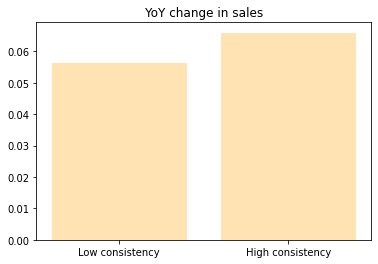

In [114]:
var_list_sales = ['xrlt_ms', 'sales_per_hcp']
titles = ['YoY change in market share',
          'YoY change in sales']

for n,feat in enumerate(var_list_sales):
    values = [df_asl[df_asl.asl.isin(c_group)].groupby('year')[feat].mean(
            ).values[1] / df_asl[df_asl.asl.isin(c_group)].groupby('year')[feat].mean().values[0] - 1,
            df_asl[df_asl.asl.isin(t_group)].groupby('year')[feat].mean(
            ).values[1] / df_asl[df_asl.asl.isin(t_group)].groupby('year')[feat].mean().values[0] - 1]
    #print(values)
    plt.bar(['Low consistency','High consistency'], values, color='orange', alpha=.3)
    #plt.legend()
    plt.title(titles[n])
    #plt.yticks([])
    plt.show()

### Additional Plots

In [111]:
var_list = ['num_touchpoints_cph',
            'num_channel_cph',
            'coverage_cph',
            'num_channel_cph',
            'consistency_4m_cph',
           'num_cph_visit',
            'num_AE_cph',
           'num_NL_cph',
           'num_hcp_call',
            'xrlt_ms',
            'sales_per_hcp'
           ]

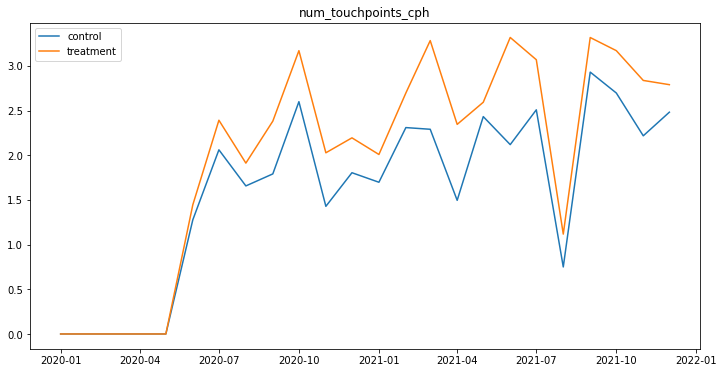

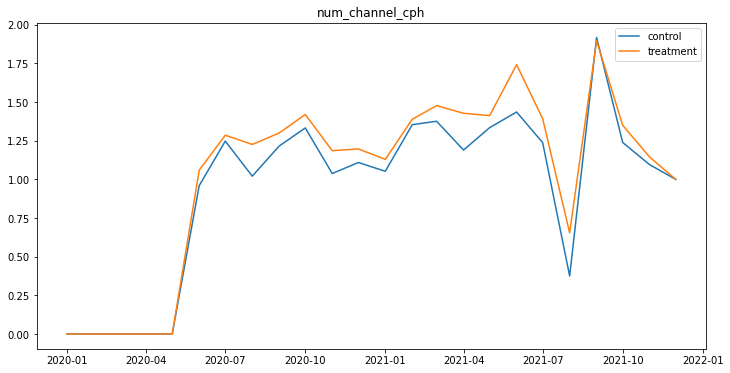

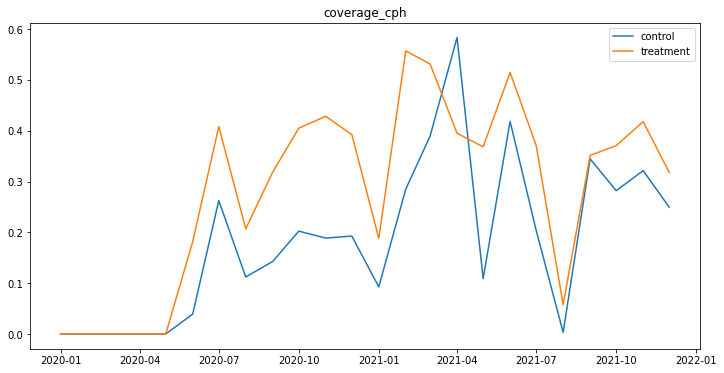

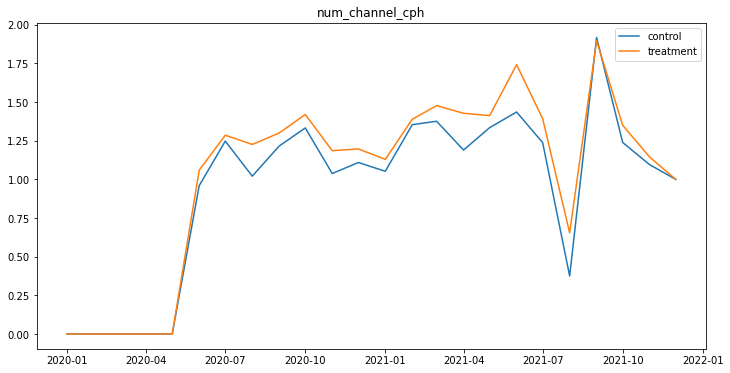

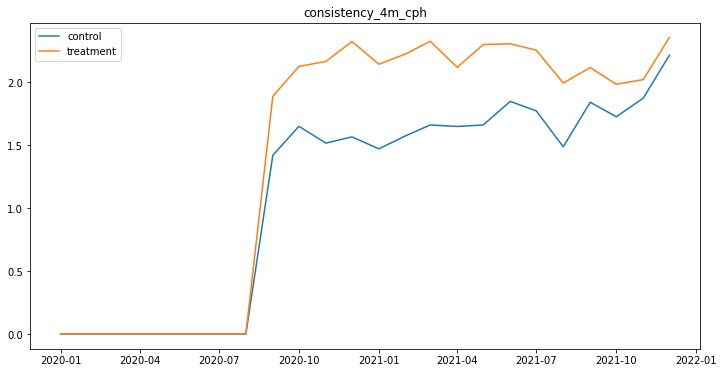

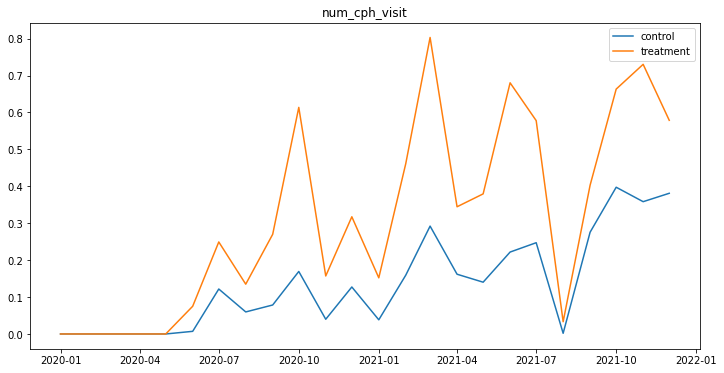

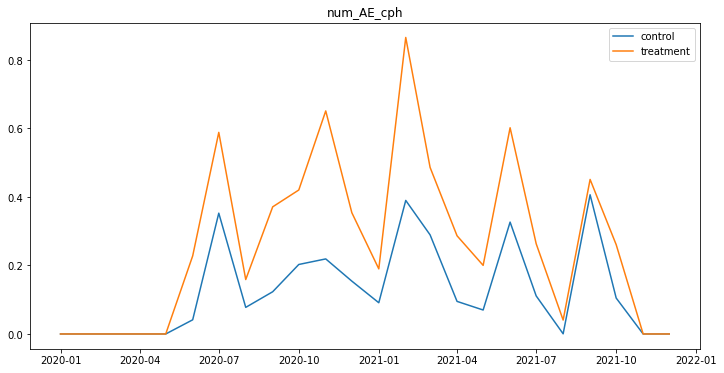

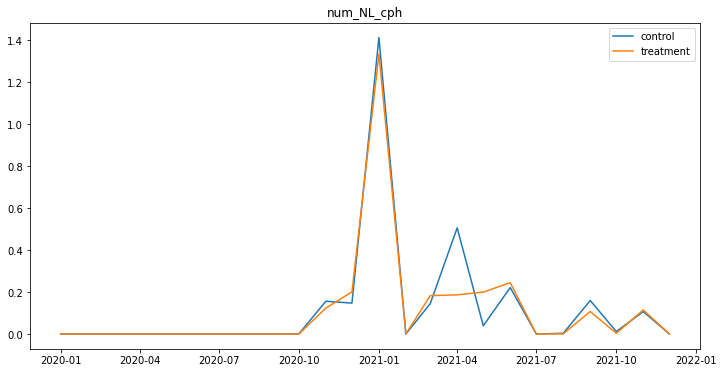

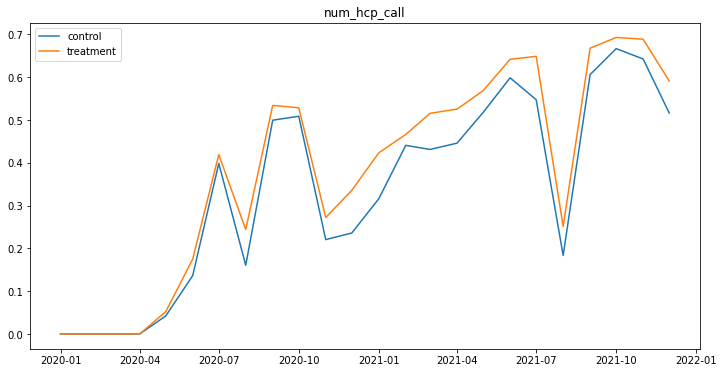

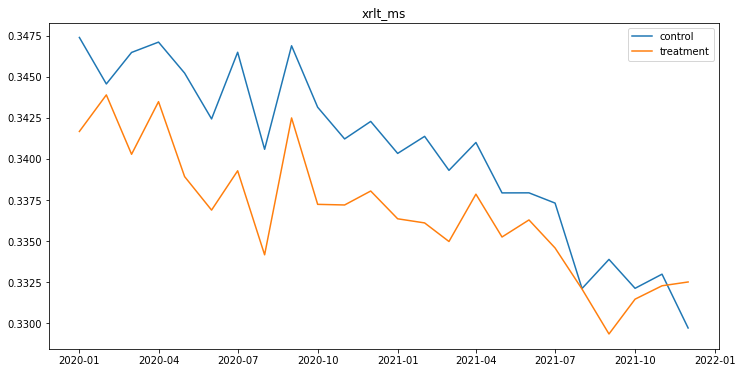

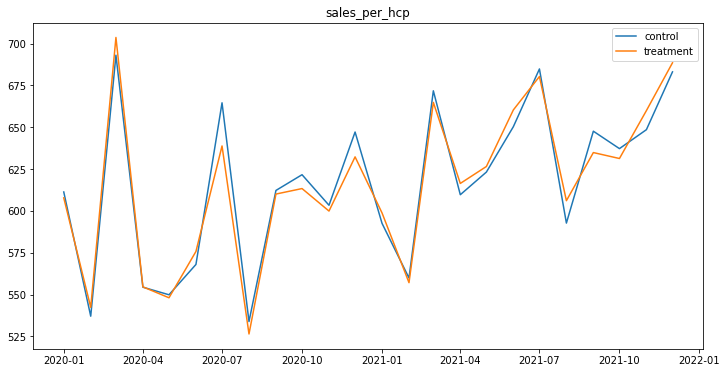

In [112]:
for feat in var_list:

    plt.figure(figsize=(12,6))
    plt.plot(df_asl[df_asl.asl.isin(c_group)].groupby('yyyymm')[feat].mean(), label='control')
    plt.plot(df_asl[df_asl.asl.isin(t_group)].groupby('yyyymm')[feat].mean(), label='treatment')
    plt.legend()
    plt.title(feat)
    plt.show()

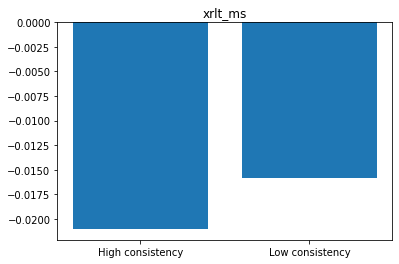

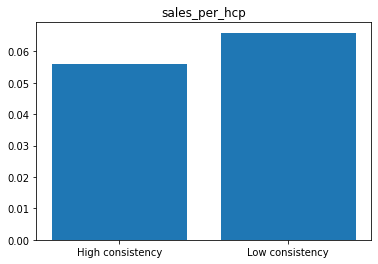

In [255]:
var_list_sales = ['xrlt_ms', 'sales_per_hcp']

for feat in var_list_sales:
    values = [df_asl[df_asl.asl.isin(c_group)].groupby('year')[feat].mean(
            ).values[1] / df_asl[df_asl.asl.isin(c_group)].groupby('year')[feat].mean().values[0] - 1,
            df_asl[df_asl.asl.isin(t_group)].groupby('year')[feat].mean(
            ).values[1] / df_asl[df_asl.asl.isin(t_group)].groupby('year')[feat].mean().values[0] - 1]
    plt.bar(['High consistency','Low consistency'], values)
    #plt.legend()
    plt.title(feat)
    plt.show()